In [119]:
import pandas as pd

df = pd.read_csv('../../input/clean_annual_wb_fred.csv')
df = df[df['year'] <= 2023]
df = df.rename(columns={"economy" : "isocode"})

df["date"] = pd.to_datetime(df["year"].astype(str) + "-01-01")
df.drop(columns="year", inplace=True)  # optional cleanup

# Selecting relevant columns
static_cols = ['isocode', 'date', '1DLGDP']
lag_cols = df.columns[df.columns.str.endswith('_L1') | df.columns.str.endswith('_L2')]
cols_to_include = static_cols + lag_cols.to_list()
df = df[cols_to_include].copy()
df = df.reset_index(drop=True)
df.drop(columns=['GDPGR_L1', '1DGDPGR_L2'], inplace=True)
print("Number of units: ", df["isocode"].nunique())
df

Number of units:  150


,isocode,date,1DLGDP,1DLGDP_L1,1DLGDP_L2,LEND_L2,RRATE_L2,1DDEBT_L2,2DLGOVCON_L1,2DLGFKF_L1,...,FEDFUNDS_L2,WUI_L1,WUI_L2,1DUST10_L2,1DUSYIELD_L1,1DUSRRATE_L2,1DFEDFUNDS_L2,1DLWTI_L2,2DLWTI_L1,1DWUI_L1
0,AFE,1980-01-01,5.318699,2.888342,1.476127,-1047.943026,3233.626846,942.444337,-0.238242,-2.852747,...,7.94,0.127085,0.049690,0.99,0.446788,0.790596,2.40,3.802009,37.321956,0.077395
1,AFE,1981-01-01,3.934116,5.318699,2.888342,-696.596459,3302.639800,2367.068244,1.894273,5.105715,...,11.20,0.062158,0.127085,1.02,2.251840,0.699691,3.26,41.123965,10.052287,-0.064928
2,AFE,1982-01-01,0.315334,3.934116,5.318699,-773.999721,3305.102706,2064.786489,-1.640130,2.037248,...,13.35,0.090546,0.062158,2.00,3.496616,1.173846,2.15,51.176252,-53.088738,0.028388
3,AFE,1983-01-01,0.039939,0.315334,3.934116,-1061.529652,3261.282561,894.782927,4.062284,-10.022484,...,16.39,0.092837,0.090546,2.49,0.737551,1.535289,3.04,-1.912486,-6.715538,0.002292
4,AFE,1984-01-01,3.310964,0.039939,0.315334,-1080.113180,3256.543016,803.989451,-2.333217,-8.376349,...,12.24,0.099054,0.092837,-0.91,-1.340747,-0.811175,-4.15,-8.628025,-1.503855,0.006217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,ZWE,2019-01-01,-6.541834,4.888413,3.999218,6.914167,-64.281571,-49.127117,-37.375893,-0.598633,...,1.00,0.192279,0.185867,0.49,0.660000,0.305207,0.61,16.500517,7.887926,0.006412
6596,ZWE,2020-01-01,-8.139392,-6.541834,4.888413,7.131667,3.454590,-57.526380,-2.954590,-7.426143,...,1.83,0.538544,0.192279,0.58,-0.290000,0.430338,0.83,24.388444,-37.454688,0.346265
6597,ZWE,2021-01-01,8.128517,-8.139392,-6.541834,16.181667,-64.295151,-41.555973,-0.342637,-16.484402,...,2.16,0.369901,0.538544,-0.77,0.070000,-0.621221,0.33,-13.066244,-24.271731,-0.168643
6598,ZWE,2022-01-01,5.958185,8.128517,-8.139392,33.008333,-81.132121,-40.365555,115.544903,32.128547,...,0.37,0.097209,0.369901,-1.25,-1.900000,-0.654452,-1.79,-37.337975,92.332019,-0.272692


In [120]:
import matplotlib.pyplot as plt

def plot_growth(df, isocodes):

    plt.figure(figsize=(7, 5))
    for isocode in isocodes:
        plt.plot(df[df['isocode'] == isocode]['date'], df[df['isocode'] == isocode]['1DLGDP'], label=f"{isocode}")
    plt.title("GDP growth evolution over time (YoY)")
    plt.xlabel("Year")
    plt.ylabel("GDP Growth")
    plt.legend()
    plt.tight_layout()
    plt.show()

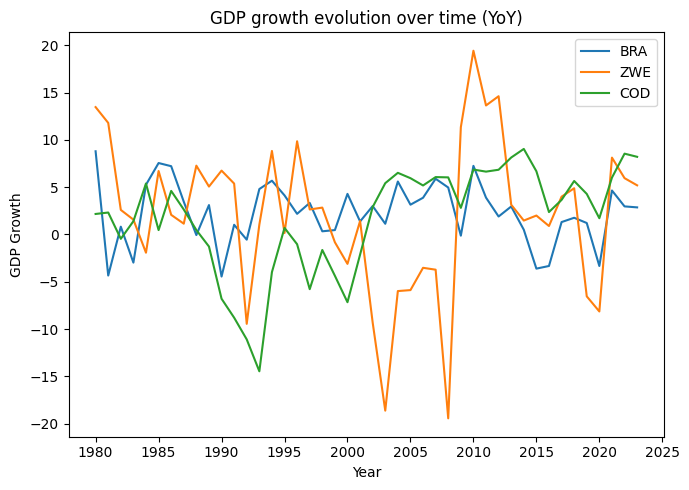

In [121]:
plot_growth(df, ["BRA", "ZWE", "COD"])

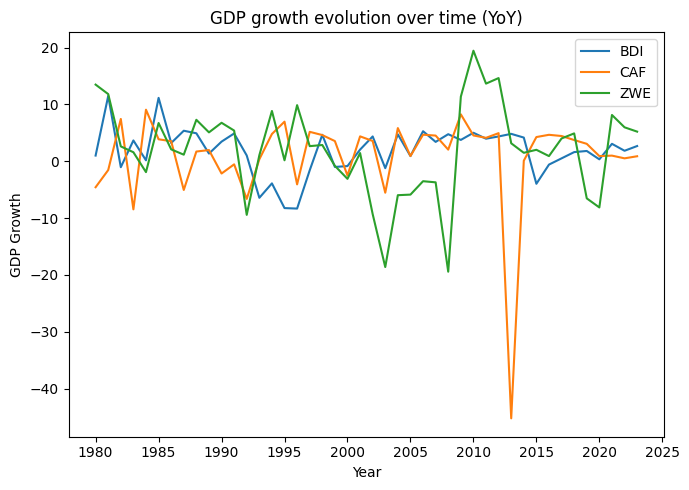

In [122]:
plot_growth(df, ["BDI", "CAF", "ZWE"])

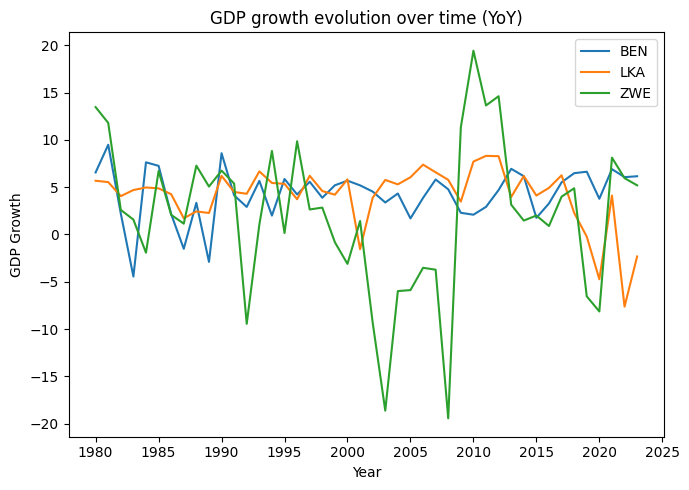

In [123]:
plot_growth(df, ["BEN", "LKA", "ZWE"])

## Analysis

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

def analyze_donor_similarity_scatter(df, model_dir):
    records = []

    for file in sorted(os.listdir(model_dir)):
        if not file.endswith(".pkl"):
            continue

        target_unit = file.replace("results_", "").replace(".pkl", "")
        model_path = os.path.join(model_dir, file)

        try:
            with open(model_path, "rb") as f:
                results = pickle.load(f)
        except Exception as e:
            print(f"⚠️ Error loading {target_unit}: {e}")
            continue

        inclusion_probs = results.get("inclusion_probs_by_donor", {})
        if not inclusion_probs:
            continue

        # Select top and worst donor based on last inclusion probability
        final_probs = {donor: probs[-1] for donor, probs in inclusion_probs.items() if len(probs) > 0}
        if not final_probs:
            continue

        top_donor = max(final_probs, key=final_probs.get)
        worst_donor = min(final_probs, key=final_probs.get)

        # --- Compute Target Unit Metrics (2010–2024)
        target_series = df[
            (df["isocode"] == target_unit) &
            (df["date"] >= pd.to_datetime("2010-01-01")) &
            (df["date"] <= pd.to_datetime("2024-12-31"))
        ]["1DLGDP"].dropna()

        target_mean = target_series.mean()
        target_std = target_series.std()

        # --- Compute Donor Metrics (pre-2010)
        donor_metrics = {}
        for donor_label, donor_unit in zip(["top_donor", "worst_donor"], [top_donor, worst_donor]):
            donor_series = df[
                (df["isocode"] == donor_unit) &
                (df["date"] < pd.to_datetime("2010-01-01"))
            ]["1DLGDP"].dropna()

            donor_metrics[f"{donor_label}_mean"] = donor_series.mean()
            donor_metrics[f"{donor_label}_std"] = donor_series.std()

        # --- Record
        records.append({
            "target_unit": target_unit,
            "target_mean": target_mean,
            "target_std": target_std,
            "top_donor_mean": donor_metrics["top_donor_mean"],
            "top_donor_std": donor_metrics["top_donor_std"],
            "worst_donor_mean": donor_metrics["worst_donor_mean"],
            "worst_donor_std": donor_metrics["worst_donor_std"]
        })

    # Create DataFrame
    df_metrics = pd.DataFrame(records)

    # --- Plotting
    plt.figure(figsize=(12, 5))

    # Scatterplot: Mean
    plt.subplot(1, 2, 1)
    plt.scatter(df_metrics["target_mean"], df_metrics["top_donor_mean"], color='red', label="Top Donor")
    plt.scatter(df_metrics["target_mean"], df_metrics["worst_donor_mean"], color='blue', label="Worst Donor")
    plt.plot([-0.2, 0.2], [-0.2, 0.2], 'k--', linewidth=1)
    plt.xlabel("Target Unit Mean (2010–2024)")
    plt.ylabel("Donor Mean (pre-2010)")
    plt.title("GDP Growth Means: Target vs. Donors")
    plt.legend()
    plt.grid(True)

    # Scatterplot: Std Dev
    plt.subplot(1, 2, 2)
    plt.scatter(df_metrics["target_std"], df_metrics["top_donor_std"], color='red', label="Top Donor")
    plt.scatter(df_metrics["target_std"], df_metrics["worst_donor_std"], color='blue', label="Worst Donor")
    plt.plot([0, 0.1], [0, 0.1], 'k--', linewidth=1)
    plt.xlabel("Target Unit Std Dev (2010–2024)")
    plt.ylabel("Donor Std Dev (pre-2010)")
    plt.title("GDP Growth Volatility: Target vs. Donors")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return df_metrics

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

def analyze_donor_crisis_alignment(df, model_dir, contraction_threshold=-10):
    """
    Identify and visualize crisis history alignment between targets and their top donors.
    """
    crisis_records = []

    for file in sorted(os.listdir(model_dir)):
        if not file.endswith(".pkl"):
            continue

        target_unit = file.replace("results_", "").replace(".pkl", "")
        model_path = os.path.join(model_dir, file)

        try:
            with open(model_path, "rb") as f:
                results = pickle.load(f)
            inclusion_probs = results.get("inclusion_probs_by_donor", {})
            if not inclusion_probs:
                continue
        except Exception as e:
            print(f"⚠️ Error loading {target_unit}: {e}")
            continue

        final_probs = {donor: probs[-1] for donor, probs in inclusion_probs.items() if len(probs) > 0}
        if not final_probs:
            continue

        top_donor = max(final_probs, key=final_probs.get)

        # Check if target unit experienced sharp contraction (2010–2024)
        target_series = df[
            (df["isocode"] == target_unit) &
            (df["date"] >= pd.to_datetime("2010-01-01")) &
            (df["date"] <= pd.to_datetime("2024-12-31"))
        ]["1DLGDP"].dropna()

        target_had_crisis = (target_series <= contraction_threshold).any()

        # Check if top donor had sharp contraction pre-2010
        donor_series = df[
            (df["isocode"] == top_donor) &
            (df["date"] < pd.to_datetime("2010-01-01"))
        ]["1DLGDP"].dropna()

        donor_had_crisis = (donor_series <= contraction_threshold).any()

        crisis_records.append({
            "target_unit": target_unit,
            "target_crisis": int(target_had_crisis),
            "top_donor": top_donor,
            "donor_crisis": int(donor_had_crisis)
        })

    # --- Create DataFrame
    df_crisis = pd.DataFrame(crisis_records)

    # --- Aggregate
    grouped = df_crisis.groupby("target_crisis")["donor_crisis"].mean().reset_index()
    grouped["target_crisis"] = grouped["target_crisis"].map({0: "No-crisis Targets", 1: "Crisis Targets"})

    # --- Plot
    plt.figure(figsize=(7, 5))
    plt.bar(grouped["target_crisis"], grouped["donor_crisis"], color=["steelblue", "indianred"])
    plt.ylabel("Proportion of Top Donors with Past Crises")
    plt.title("Crisis Alignment: Targets vs. Top Donors")
    plt.ylim(0, 1)
    plt.grid(True, axis='y')

    # Add threshold as annotation
    plt.text(
        0.5, 0.9,
        f"Threshold for contraction: {contraction_threshold:.1f}%",
        ha='right', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white')
    )

    plt.tight_layout()
    plt.show()

    return df_crisis

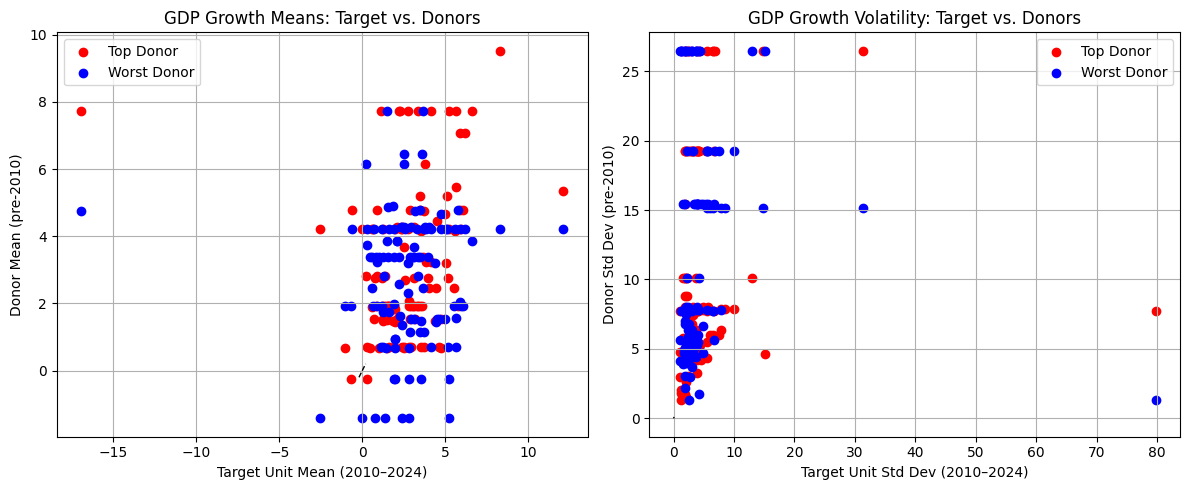

In [126]:
model_dir = "results/annual/last/models"
df_metrics = analyze_donor_similarity_scatter(df, model_dir)

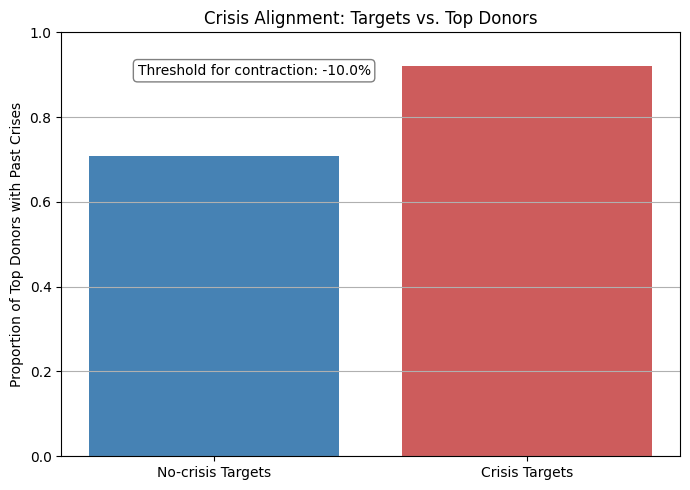

In [129]:
df_crisis = analyze_donor_crisis_alignment(df, model_dir, contraction_threshold=-10)